In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


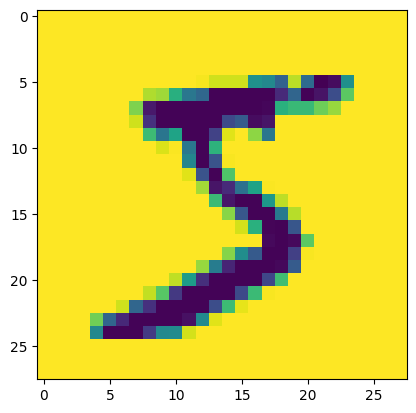

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape de los datos

X_train = X_train/255
X_train = X_train.reshape(-1, 28, 28, 1)*-1

plt.imshow(X_train[0])

In [3]:
# Reshape de los datos

X_train = X_train/255
X_train = X_train.reshape(-1, 28, 28, 1)*-1

X_train.min(), X_train.max()

(np.float64(0.0), np.float64(0.00392156862745098))

In [4]:
zeros = X_train[y_train==0]

zeros.shape

(5923, 28, 28, 1)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.models import Sequential

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=3, padding='same', activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=3, padding='same', activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))




discriminator.compile(loss='binary_crossentropy', optimizer='adam')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
encoding_size = 50

generator = Sequential()
generator.add(Dense(7*7*128, activation='relu', input_shape=[encoding_size]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))

generator.compile(loss='binary_crossentropy', optimizer='adam')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
GAN=Sequential([generator, discriminator])
discriminator.trainable=False

GAN.compile(loss='binary_crossentropy', optimizer='adam')

discriminator.trainable=False

In [8]:
batch_size=32

data=zeros
dataset=tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000)

dataset=dataset.batch(batch_size, drop_remainder=True).prefetch(1)

epochs=1

GAN.layers


[<Sequential name=sequential_1, built=True>,
 <Sequential name=sequential, built=True>]

In [14]:
generator, discriminator = GAN.layers

discriminator_optimizer = tf.keras.optimizers.Adam()
generator_optimizer = tf.keras.optimizers.Adam()

binary_crossentropy = tf.keras.losses.BinaryCrossentropy()


discriminator.trainable = True


epochs=20


for epoch in range(epochs):
  print(f'Current epoch{epoch+1}')
  i=0

  for real_images in dataset:


    # Entrenamiento del discriminador
    discriminator.trainable = True

    noise=tf.random.normal(shape=[batch_size, encoding_size])
    gen_images=generator(noise)

    fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(real_images, tf.float32)], axis=0)
    labels = tf.concat([tf.zeros(shape=[batch_size, 1]), tf.ones(shape=[batch_size, 1])], axis=0) # Labels for fake (0) and real (1) images

    with tf.GradientTape() as discriminator_tape:
        predictions = discriminator(fake_vs_real)
        discriminator_loss = binary_crossentropy(labels, predictions)

    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    # Entrenamiento del generador
    discriminator.trainable = False

    noise=tf.random.normal(shape=[batch_size, encoding_size])
    labels_2 = tf.ones(shape=[batch_size, 1])

    with tf.GradientTape() as generator_tape:
        gen_images = generator(noise)
        predictions = discriminator(gen_images)
        generator_loss = binary_crossentropy(labels_2, predictions)

    gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    i+=1

Current epoch1
Current epoch2
Current epoch3
Current epoch4
Current epoch5
Current epoch6
Current epoch7
Current epoch8
Current epoch9
Current epoch10
Current epoch11
Current epoch12
Current epoch13
Current epoch14
Current epoch15
Current epoch16
Current epoch17
Current epoch18
Current epoch19
Current epoch20


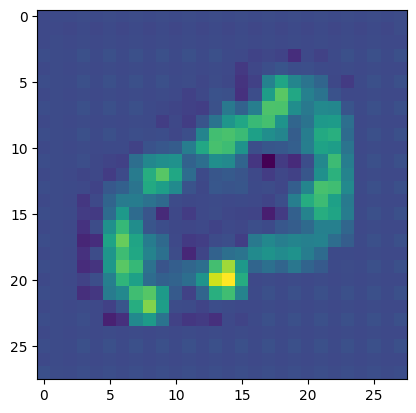

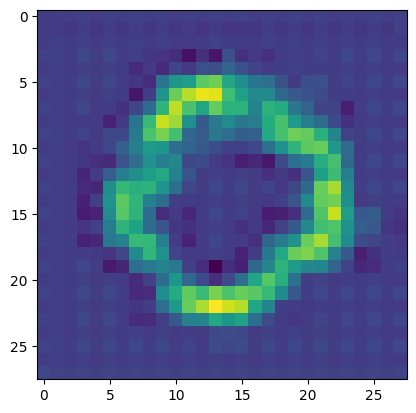

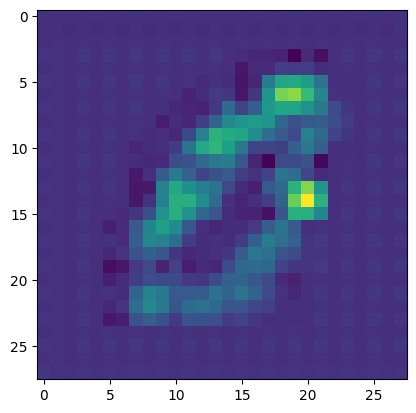

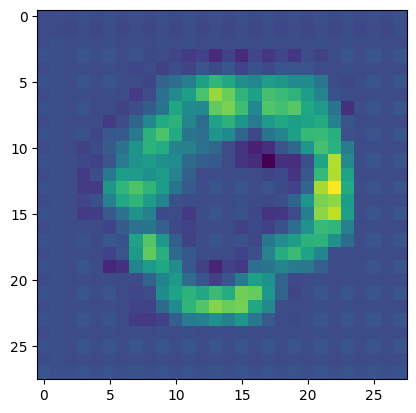

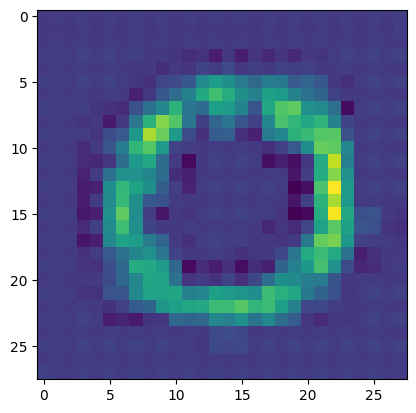

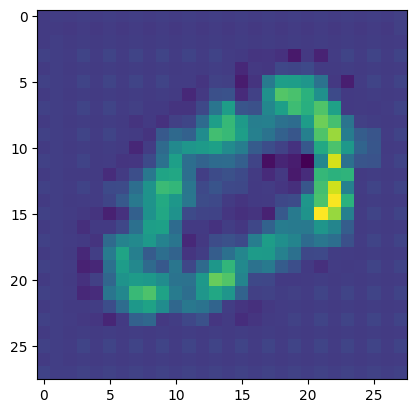

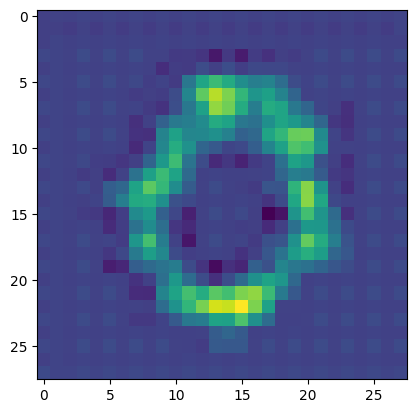

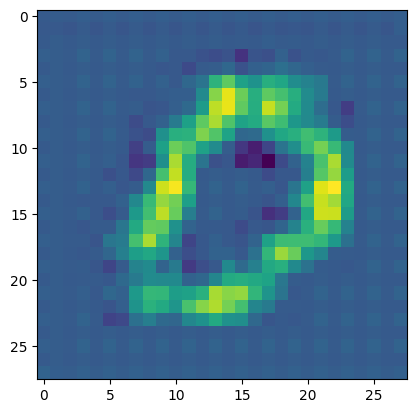

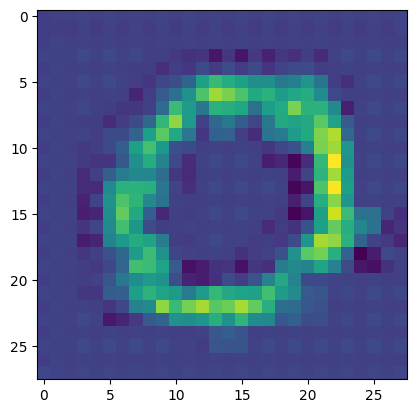

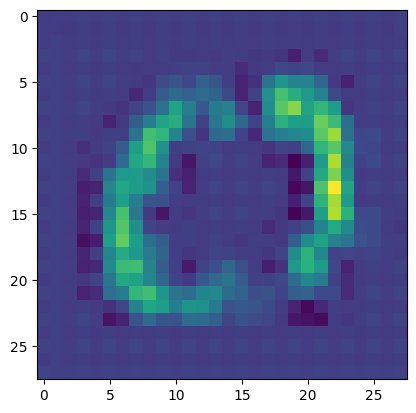

In [16]:
# Imagenes creadas por la red

noise = tf.random.normal(shape=[10, encoding_size])
generated_images = generator(noise)

for i in range(10):
  plt.imshow(generated_images[i, :, :, 0])
  plt.show()
